In [1]:
from All_Functions_FF import * 

In [2]:
##################### Data preparation ###################

data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)


# monthly data
index_1927 = data["Year"].to_list().index(1927)
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

By removing outliers w.r.t y, the number of data being removed is  65


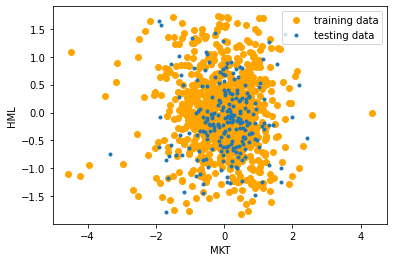

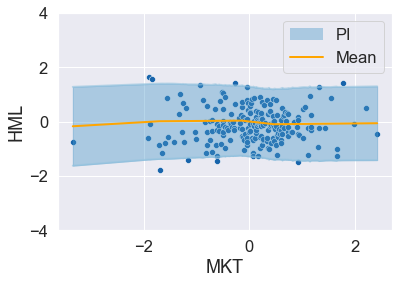

The overall coverage is 0.9634703196347032
The mean bandwidth for testing data is 1.7187380589063348
The median bandwidth for testing data is 1.6895437910642164


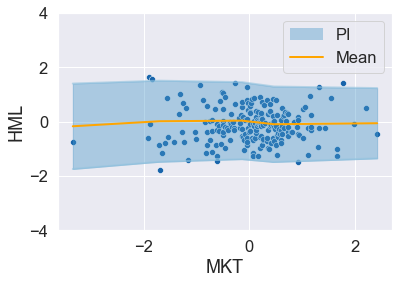

The overall coverage is 0.9726027397260274
The mean bandwidth for testing data is 1.9834954299691172
The median bandwidth for testing data is 1.9723343900069057


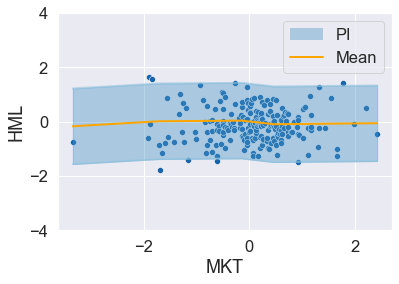

The overall coverage is 0.9726027397260274
The mean bandwidth for testing data is 1.9342488693663629
The median bandwidth for testing data is 1.9342488693663622


In [3]:
################################ MKT VS HML #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "HML"
X = MKT_te
Y = HML_te

# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]
#print("By constraint on [-1.5,1.5], the number of data being removed is ", MKT_te.shape[0]-X.shape[0])

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

# np.random.seed(2)
# np.random.shuffle(Data)
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])

########################### UTOPIA #########################

X_pre = train_data[:,0].reshape(-1,1)
Y_pre = train_data[:,1].reshape(-1,1)
X_opt = train_data[:,0].reshape(-1,1)
Y_opt = train_data[:,1].reshape(-1,1)
X_adj = train_data[:,0].reshape(-1,1)
Y_adj = train_data[:,1].reshape(-1,1)
X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_opt,Y_opt,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()

# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN1"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
    
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")


    
# Obtain quantile estimators
quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 2)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
#my_plot(X_t,Y_t,M_t,V100_t)
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])



########################### LQR #########################

# lin_idx = int(Data.shape[0] * 0.4)
# quantile_idx = int(Data.shape[0] * 0.8)
# lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

# X_lin = lin_data[:,0].reshape(-1,1)
# Y_lin = lin_data[:,1].reshape(-1,1)
# y_lin = Y_lin[:,0]
# X_quantile = quantile_data[:,0].reshape(-1,1)
# Y_quantile = quantile_data[:,1].reshape(-1,1)
# X_test = test_data[:,0].reshape(-1,1)
# Y_test = test_data[:,1].reshape(-1,1)


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = train_data[:,0].reshape(-1,1)
Y_quantile = train_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



########################### SPLIT CF #########################

# lin_idx = int(Data.shape[0] * 0.4)
# res_idx = int(Data.shape[0] * 0.8)
# lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = train_data[:,0].reshape(-1,1)
Y_res = train_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
Y_res_pred, M_test = mean_est_2(est_type,X_lin,Y_lin,X_res,X_test)
y_res_pred = Y_res_pred[:,0]

# Calculate the conformity scores
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

By removing outliers w.r.t y, the number of data being removed is  34


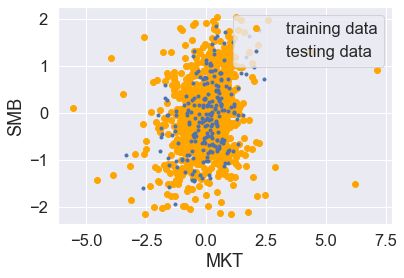

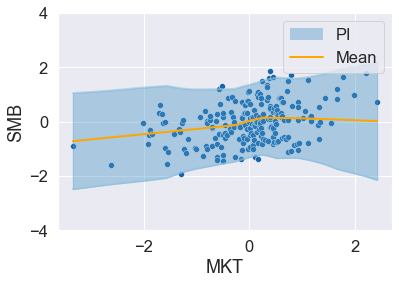

The overall coverage is 0.9601769911504425
The mean bandwidth for testing data is 2.1033285728635462
The median bandwidth for testing data is 1.975837648102547


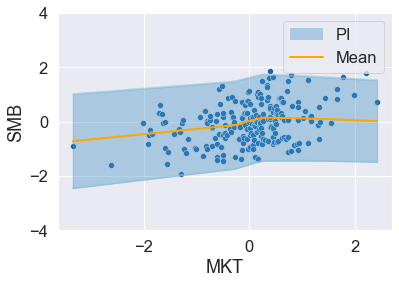

The overall coverage is 0.9823008849557522
The mean bandwidth for testing data is 2.5460030088514563
The median bandwidth for testing data is 2.5332071023510645


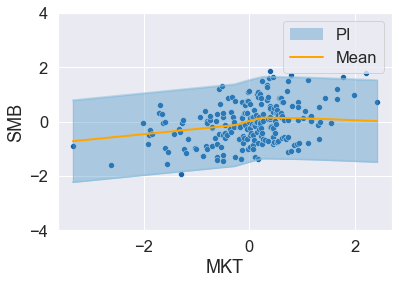

The overall coverage is 0.9778761061946902
The mean bandwidth for testing data is 2.2629113694554945
The median bandwidth for testing data is 2.2629113694554945


In [4]:
################################ MKT VS SMB #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "SMB"
X = MKT_te
Y = SMB_te

# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]
#print("By constraint on [-1.5,1.5], the number of data being removed is ", MKT_te.shape[0]-X.shape[0])

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

# np.random.seed(2)
# np.random.shuffle(Data)
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])

########################### UTOPIA #########################

X_pre = train_data[:,0].reshape(-1,1)
Y_pre = train_data[:,1].reshape(-1,1)
X_opt = train_data[:,0].reshape(-1,1)
Y_opt = train_data[:,1].reshape(-1,1)
X_adj = train_data[:,0].reshape(-1,1)
Y_adj = train_data[:,1].reshape(-1,1)
X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_opt,Y_opt,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()

# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN1"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
    
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")


    
# Obtain quantile estimators
quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 2)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
#my_plot(X_t,Y_t,M_t,V100_t)
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])



########################### LQR #########################

# lin_idx = int(Data.shape[0] * 0.4)
# quantile_idx = int(Data.shape[0] * 0.8)
# lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = train_data[:,0].reshape(-1,1)
Y_quantile = train_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



########################### SPLIT CF #########################

# lin_idx = int(Data.shape[0] * 0.4)
# res_idx = int(Data.shape[0] * 0.8)
# lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = train_data[:,0].reshape(-1,1)
Y_res = train_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
Y_res_pred, M_test = mean_est_2(est_type,X_lin,Y_lin,X_res,X_test)
y_res_pred = Y_res_pred[:,0]

# Calculate the conformity scores
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

By removing outliers w.r.t y, the number of data being removed is  17


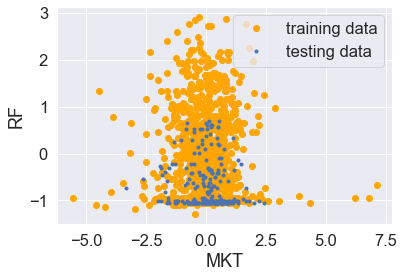

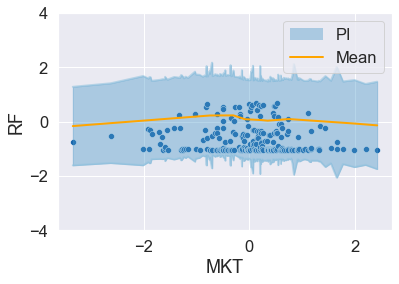

The overall coverage is 1.0
The mean bandwidth for testing data is 2.3186251838371743
The median bandwidth for testing data is 2.1779023137765834


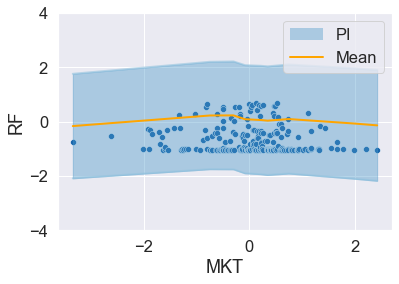

The overall coverage is 1.0
The mean bandwidth for testing data is 3.9644514670709516
The median bandwidth for testing data is 3.971152937433904


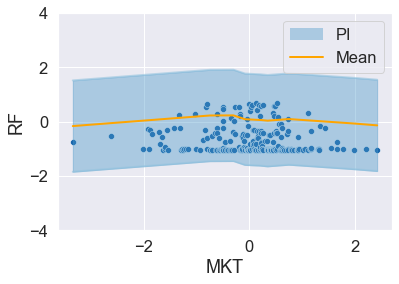

The overall coverage is 1.0
The mean bandwidth for testing data is 2.822499277826357
The median bandwidth for testing data is 2.8224992778263576


In [5]:
################################ MKT VS RF #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "RF"
X = MKT_te
Y = RF_te

# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]
#print("By constraint on [-1.5,1.5], the number of data being removed is ", MKT_te.shape[0]-X.shape[0])

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

# np.random.seed(2)
# np.random.shuffle(Data)
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])

########################### UTOPIA #########################


X_pre = train_data[:,0].reshape(-1,1)
Y_pre = train_data[:,1].reshape(-1,1)
X_opt = train_data[:,0].reshape(-1,1)
Y_opt = train_data[:,1].reshape(-1,1)
X_adj = train_data[:,0].reshape(-1,1)
Y_adj = train_data[:,1].reshape(-1,1)
X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_opt,Y_opt,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()

# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN1"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
    
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")


    
# Obtain quantile estimators
quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 2)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
#my_plot(X_t,Y_t,M_t,V100_t)
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])



########################### LQR #########################

# lin_idx = int(Data.shape[0] * 0.4)
# quantile_idx = int(Data.shape[0] * 0.8)
# lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = train_data[:,0].reshape(-1,1)
Y_quantile = train_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



########################### SPLIT CF #########################

# lin_idx = int(Data.shape[0] * 0.4)
# res_idx = int(Data.shape[0] * 0.8)
# lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = train_data[:,0].reshape(-1,1)
Y_res = train_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

# Estimate the mean using NN1
est_type = "NN1"
Y_res_pred, M_test = mean_est_2(est_type,X_lin,Y_lin,X_res,X_test)
y_res_pred = Y_res_pred[:,0]

# Calculate the conformity scores
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(len(y_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])